
## Mini Challenge: Gradient Descent – Notebook
 
 **Inhalt:**
 
 1. **Aufgabe 1:** Laden und Erkunden des MNIST-Datensatzes  
    - Verwendung von `torchvision` und `matplotlib` zur Visualisierung und Analyse der Daten.
 
 2. **Aufgabe 2:** Implementierung eines linearen Layers  
    - Erstellung einer Klasse `LinearLayer` mit Methoden für Forward-Pass, Backward-Pass und Parameter-Update.  
    - Unittests anhand eines kleinen Beispiels mit handberechneten Ergebnissen.
 
 3. **Aufgabe 3:** Aufbau eines einfachen neuronalen Netzwerks (mit einem Hidden Layer) zur binären Klassifikation  
    - Ziel: Erkennung einer bestimmten Ziffer (z.B. 7).  
    - Implementierung der Aktivierungsfunktionen (ReLU, Sigmoid), der Kostenfunktion (Binary Cross Entropy) sowie des Trainingsloops.
 
 4. **Aufgabe 4:** Training des Netzwerks für verschiedene Hyperparameter  
    - Variation von Lernraten und Hidden-Layer-Größen und Auswertung anhand von Kosten- und Evaluationsmetriken.
 
 5. **Aufgabe 5:** Erweiterung des Netzwerks auf drei Hidden Layers für die Mehrklassenklassifikation  
    - Implementierung eines Netzwerks mit Mini-Batch Training, Softmax-Aktivierung, Cross-Entropy-Kostenfunktion und Experimenten zu Lernraten und Layer-Größen.
 
 *Hinweis:* Für Aufgabe 1 wird `torchvision` verwendet – in den folgenden Aufgaben kommen nur noch `numpy`, `matplotlib` und Python Built-ins zum Einsatz.


### Aufgabe 1: MNIST-Datensatz laden und erkunden

In [59]:

import numpy as np
import matplotlib.pyplot as plt

# Für Aufgabe 1: Verwendung von torchvision
from torchvision import datasets, transforms

# Definieren des Transforms: Wir wandeln das Bild in einen Tensor um.
transform = transforms.ToTensor()

# MNIST-Datensatz laden (Training und Test)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print("Trainingsdaten: ", len(train_dataset))
print("Testdaten: ", len(test_dataset))

Trainingsdaten:  60000
Testdaten:  10000


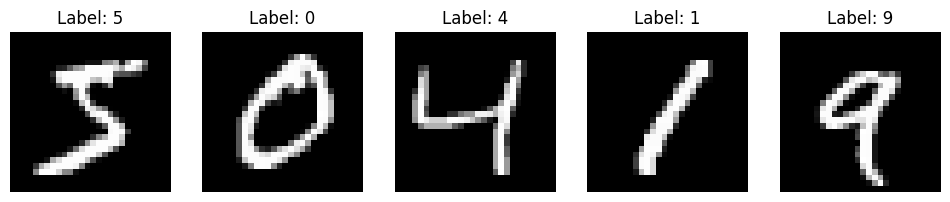

In [60]:
# Visualisieren Sie einige Beispiele aus dem Trainingsdatensatz
fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

**Hilfsfunktion: Konvertieren des Datasets in numpy Arrays**

Für die nachfolgenden Aufgaben (2–5) extrahieren wir die Bilder und Labels aus dem MNIST-Datensatz und wandeln sie in numpy Arrays um.  
Dabei wird das Bild (1x28x28) zu einem Vektor (28*28 = 784) umgeformt.

In [61]:
def dataset_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.numpy().reshape(-1))
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test   = dataset_to_numpy(test_dataset)

# Für die binäre Klassifikation (Aufgabe 3–4) definieren wir:
# Ziel: Erkenne die Ziffer 7 (1, falls Label == 7, sonst 0)
y_train_bin = (y_train == 7).astype(np.int32)
y_test_bin  = (y_test == 7).astype(np.int32)

print("X_train shape:", X_train.shape)
print("y_train_bin shape:", y_train_bin.shape)

X_train shape: (60000, 784)
y_train_bin shape: (60000,)


### Aufgabe 2: Implementierung eines linearen Layers

 Wir erstellen eine Klasse `LinearLayer`, die folgende Methoden besitzt:
 
 - `forward(x)`: Berechnet die Ausgabe \( z = xW^T + b \)
 - `backward(d_out)`: Berechnet die Gradienten (basierend auf dem gespeicherten Input)  
 - `update(learning_rate)`: Aktualisiert die Parameter mittels Gradient Descent
 
Anschließend folgt ein Unittest, der anhand eines kleinen Beispiels (mit handberechneten Ergebnissen) die Funktionsweise überprüft.

In [62]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        # Initialisierung der Gewichte (W) und Bias (b)
        # He-Initialization für ReLU: Skaliere die zufälligen Gewichte mit sqrt(2/input_dim)
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((output_dim, 1))
        # Platzhalter für Zwischenergebnisse
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        # x: (batch_size, input_dim)
        self.x = x  # für Backward-Pass speichern
        # Berechnung: x * W^T + b^T
        out = x.dot(self.W.T) + self.b.T
        return out

    def backward(self, d_out):
        # d_out: (batch_size, output_dim)
        batch_size = self.x.shape[0]
        self.dW = (d_out.T.dot(self.x)) / batch_size
        self.db = (np.sum(d_out, axis=0, keepdims=True).T) / batch_size
        # Gradient bezüglich des Inputs
        dx = d_out.dot(self.W)
        return dx

    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

**Unittest für LinearLayer**
 
 Wir definieren einen Test für ein Layer mit 2 Knoten und 2 Datensätzen (jeweils 2 floats).
 
 Gegebene Testwerte:
 
 - **Input:**  

   $ X = \begin{pmatrix} 1.0 & 2.0 \\ 3.0 & 4.0 \end{pmatrix} $
 
 - **Initiale Parameter:**  

   $ W = \begin{pmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{pmatrix}, \quad b = \begin{pmatrix} 0.5 \\ 0.6 \end{pmatrix} $
 
 - **Forward-Berechnung:**  

    $ X \cdot W^T = \begin{pmatrix} 0.5 & 1.1 \\ 1.1 & 2.5 \end{pmatrix}  $

    $ \text{out} = X \cdot W^T + b^T = \begin{pmatrix} 1.0 & 1.7 \\ 1.6 & 3.1 \end{pmatrix} $
 
 - **Backward-Pass:**  

   Mit $ d\_out = \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix} $ und Batchgröße 2,  

    $ dW = \begin{pmatrix} 2 & 3 \\ 2 & 3 \end{pmatrix} $ und $ db = \begin{pmatrix} 1 \\ 1 \end{pmatrix} $.
 
 - **Update (mit Lernrate 0.1):**  

   Neue Parameter:  

   $ W_{neu} = \begin{pmatrix} -0.1 & -0.1 \\ 0.1 & 0.1 \end{pmatrix} $, 
   $ b_{neu} = \begin{pmatrix} 0.4 \\ 0.5 \end{pmatrix} $.

In [63]:
def test_linear_layer():
    # Feste Testwerte
    X_test_input = np.array([[1.0, 2.0],
                             [3.0, 4.0]])
    
    # Erstellen eines Layers und manuelles Setzen der Parameter
    layer = LinearLayer(input_dim=2, output_dim=2)
    layer.W = np.array([[0.1, 0.2],
                        [0.3, 0.4]])
    layer.b = np.array([[0.5],
                        [0.6]])
    
    # Forward-Pass
    out = layer.forward(X_test_input)
    expected_out = np.array([[1.0, 1.7],
                             [1.6, 3.1]])
    assert np.allclose(out, expected_out, atol=1e-6), f"Forward-Pass fehlerhaft: {out} != {expected_out}"
    
    # Backward-Pass
    d_out = np.ones((2,2))
    layer.backward(d_out)
    # Erwartete Gradienten ohne zusätzliche Division, da backward() bereits durch die Batchgröße teilt.
    expected_dW = np.array([[2, 3],
                            [2, 3]])
    expected_db = np.array([[1],
                            [1]])
    
    assert np.allclose(layer.dW, expected_dW, atol=1e-6), f"dW fehlerhaft: {layer.dW} != {expected_dW}"
    assert np.allclose(layer.db, expected_db, atol=1e-6), f"db fehlerhaft: {layer.db} != {expected_db}"
    
    # Parameter-Update mit Lernrate 0.1
    learning_rate = 0.1
    layer.update(learning_rate)
    expected_W_new = np.array([[0.1, 0.2],
                               [0.3, 0.4]]) - 0.1 * expected_dW
    expected_b_new = np.array([[0.5],
                               [0.6]]) - 0.1 * expected_db
    assert np.allclose(layer.W, expected_W_new, atol=1e-6), f"W update fehlerhaft: {layer.W} != {expected_W_new}"
    assert np.allclose(layer.b, expected_b_new, atol=1e-6), f"b update fehlerhaft: {layer.b} != {expected_b_new}"
    
    print("Unittest für LinearLayer erfolgreich bestanden.")

# Test ausführen
test_linear_layer()

Unittest für LinearLayer erfolgreich bestanden.


### Aufgabe 3: Einfaches neuronales Netzwerk ( binäre Klassifikation )
 
 **Ziel:** Ein Netzwerk, das anhand eines versteckten (Hidden) linearen Layers die Ziffer 7 (1) von allen anderen (0) unterscheidet.
 
 Wir implementieren:
 
 - **Aktivierungsfunktionen:** ReLU (für den Hidden Layer) und Sigmoid (für den Output)  
 - **Kostenfunktion:** Binary Cross Entropy (BCE)  
 - **Trainingsloop:** Vollständiger Batch-Training (ohne Mini-Batches)
 
 **Mathematische Definition der Binary Cross Entropy:**  

 $
L = -\frac{1}{N}\sum_{i=1}^{N} \Big[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\Big]
 $
 
 _Hinweis:_ Für die Ableitungen nutzen wir die Eigenschaft, dass bei Verwendung von Sigmoid in Kombination mit der BCE der Gradiententerm vereinfacht zu $\hat{y} - y$ wird.

In [64]:
# Aktivierungsfunktionen und deren Ableitungen
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

In [65]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialisierung der beiden linearen Layer
        self.layer1 = LinearLayer(input_dim, hidden_dim)
        self.layer2 = LinearLayer(hidden_dim, output_dim)
        
    def forward(self, x):
        # Vorwärtsdurchlauf:
        # Hidden Layer: Linearer Transform gefolgt von ReLU
        self.z1 = self.layer1.forward(x)
        self.a1 = relu(self.z1)
        # Output Layer: Linearer Transform gefolgt von Sigmoid
        self.z2 = self.layer2.forward(self.a1)
        self.a2 = sigmoid(self.z2)
        return self.a2
    
    def backward(self, x, y, output, weight_pos=3):
        """
        Berechnet den Gradienten unter Berücksichtigung einer Gewichtung für positive Beispiele.
        weight_pos: Gewichtungsfaktor für Beispiele, bei denen y == 1 (z.B. Ziffer 7).
        """
        # Erzeuge einen Gewichtungsfaktor: Bei y==1 wird weight_pos verwendet, sonst 1.
        weight_factor = np.where(y.reshape(-1, 1) == 1, weight_pos, 1)
        # Angepasster Fehler: (output - y) multipliziert mit dem Gewichtungsfaktor
        dz2 = (output - y.reshape(-1, 1)) * weight_factor
        # Backward-Pass durch den Output-Layer; liefert den Gradienten bezüglich der Hidden-Aktivierung zurück
        da1 = self.layer2.backward(dz2)
        # Gradient des Hidden Layers: Multiplikation mit der Ableitung der ReLU-Funktion
        dz1 = da1 * relu_derivative(self.z1)
        # Backward-Pass durch den Hidden Layer
        self.layer1.backward(dz1)
    
    def update(self, learning_rate):
        # Aktualisierung der Parameter beider Layer mittels Gradient Descent
        self.layer1.update(learning_rate)
        self.layer2.update(learning_rate)

In [66]:
# Kostenfunktion (Binary Cross Entropy) und Accuracy
def compute_loss(y_true, y_pred):
    epsilon = 1e-8
    loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return loss

# Gewichteter Loss, um die Klassenungleichheit ( 7 vs. Rest der Ziffern ) auszugleichen
def compute_loss_weighted(y_true, y_pred, weight_pos=3):
    epsilon = 1e-8
    loss = -np.mean(weight_pos * y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return loss

def compute_accuracy(y_true, y_pred):
    preds = (y_pred >= 0.5).astype(int).flatten()
    return np.mean(preds == y_true)

In [67]:
# Trainingsloop
def train_binary_nn_weighted(model, X, y, epochs, learning_rate, weight_pos=3):
    loss_history = []
    acc_history = []
    for epoch in range(epochs):
        # Vorwärtsdurchlauf
        output = model.forward(X)
        # Berechne den gewichteten Loss
        loss = compute_loss_weighted(y, output, weight_pos)
        # Berechne die Accuracy (diese bleibt natürlich weiterhin über den Schwellenwert definiert)
        acc = compute_accuracy(y, output)
        loss_history.append(loss)
        acc_history.append(acc)
        
        # Rückwärtsdurchlauf mit Gewichtung im Gradienten
        model.backward(X, y, output, weight_pos)
        model.update(learning_rate)
        
        print(f"Epoch {epoch+1}/{epochs} – Loss: {loss:.4f}, Accuracy: {acc*100:.2f}%")
    return loss_history, acc_history

### Training des binären Netzwerks (Aufgabe 3 & 4)
 
 Wir wählen:
 - Input-Dimension: 784  
 - Hidden-Dimension: 32 (wird später variiert)  
 - Output-Dimension: 1  
 - Lernrate: 0.1 (wird später variiert)
 
 Die Daten sind bereits vorbereitet:
 
 `X_train` (Trainingsbilder, flach), `y_train_bin` (Labels: 1, falls Ziffer 7, sonst 0)

In [68]:
# Für die Experimente verwenden wir nur einen Teil der Trainingsdaten (z.B. 5000 Beispiele)
sample_size = 5000
X_train_sample = X_train[:sample_size]
y_train_bin_sample = y_train_bin[:sample_size]

# Hyperparameter für das initiale Training
input_dim = 784
hidden_dim = 32
output_dim = 1
epochs = 10
learning_rate = 0.01

# Initialisiere das Netzwerk
binary_nn = SimpleNN(input_dim, hidden_dim, output_dim)

# Training
loss_hist, acc_hist = train_binary_nn_weighted(binary_nn, X_train_sample, y_train_bin_sample, epochs, learning_rate)

# Evaluierung auf Testdaten
test_output = binary_nn.forward(X_test)
test_loss = compute_loss_weighted(y_test_bin, test_output)
test_acc = compute_accuracy(y_test_bin, test_output)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/10 – Loss: 1.0592, Accuracy: 18.52%
Epoch 2/10 – Loss: 0.9770, Accuracy: 27.90%
Epoch 3/10 – Loss: 0.9152, Accuracy: 40.08%
Epoch 4/10 – Loss: 0.8696, Accuracy: 54.52%
Epoch 5/10 – Loss: 0.8364, Accuracy: 66.06%
Epoch 6/10 – Loss: 0.8123, Accuracy: 73.38%
Epoch 7/10 – Loss: 0.7949, Accuracy: 78.96%
Epoch 8/10 – Loss: 0.7823, Accuracy: 82.68%
Epoch 9/10 – Loss: 0.7731, Accuracy: 85.24%
Epoch 10/10 – Loss: 0.7665, Accuracy: 86.62%

Test Loss: 0.7424, Test Accuracy: 88.03%


### Aufgabe 4: Experimente mit unterschiedlichen Hyperparametern
 
 Wir variieren:
 - **Lernrate:** 0.01, 0.1, 1.0  
 - **Hidden-Layer-Größe:** 4, 8, 16
 
 Für jede Kombination trainieren wir 10 Epochen und protokollieren den Test-Accuracy.

In [69]:
# Für die Experimente verwenden wir nur einen Teil der Trainingsdaten (z.B. 5000 Beispiele)
sample_size = 5000
X_train_sample = X_train[:sample_size]
y_train_bin_sample = y_train_bin[:sample_size]

learning_rates = [0.01, 0.1, 1.0]
hidden_sizes = [4, 8, 16]
results = {}

for lr in learning_rates:
    for h_dim in hidden_sizes:
        print(f"\nTraining mit Lernrate={lr} und Hidden-Dimension={h_dim}")
        model = SimpleNN(input_dim, h_dim, output_dim)
        train_binary_nn_weighted(model, X_train_sample, y_train_bin_sample, epochs=10, learning_rate=lr)
        test_out = model.forward(X_test)
        acc = compute_accuracy(y_test_bin, test_out)
        results[(lr, h_dim)] = acc
        print(f"Test Accuracy: {acc*100:.2f}%")

print("\nErgebnisse der Hyperparameter-Experimente:")
for key, acc in results.items():
    print(f"Lernrate {key[0]}, Hidden {key[1]} -> Accuracy: {acc*100:.2f}%")


Training mit Lernrate=0.01 und Hidden-Dimension=4
Epoch 1/10 – Loss: 0.7898, Accuracy: 83.46%
Epoch 2/10 – Loss: 0.7860, Accuracy: 86.34%
Epoch 3/10 – Loss: 0.7822, Accuracy: 86.78%
Epoch 4/10 – Loss: 0.7783, Accuracy: 87.16%
Epoch 5/10 – Loss: 0.7744, Accuracy: 87.58%
Epoch 6/10 – Loss: 0.7705, Accuracy: 87.84%
Epoch 7/10 – Loss: 0.7668, Accuracy: 88.10%
Epoch 8/10 – Loss: 0.7632, Accuracy: 88.28%
Epoch 9/10 – Loss: 0.7598, Accuracy: 88.44%
Epoch 10/10 – Loss: 0.7566, Accuracy: 88.48%
Test Accuracy: 89.33%

Training mit Lernrate=0.01 und Hidden-Dimension=8
Epoch 1/10 – Loss: 0.8518, Accuracy: 47.16%
Epoch 2/10 – Loss: 0.8251, Accuracy: 59.72%
Epoch 3/10 – Loss: 0.8050, Accuracy: 69.20%
Epoch 4/10 – Loss: 0.7897, Accuracy: 75.04%
Epoch 5/10 – Loss: 0.7779, Accuracy: 79.48%
Epoch 6/10 – Loss: 0.7687, Accuracy: 82.32%
Epoch 7/10 – Loss: 0.7613, Accuracy: 84.34%
Epoch 8/10 – Loss: 0.7554, Accuracy: 85.52%
Epoch 9/10 – Loss: 0.7507, Accuracy: 86.30%
Epoch 10/10 – Loss: 0.7469, Accuracy: 8

### Aufgabe 5: Erweiterung auf ein Netzwerk für Mehrklassenklassifikation
 
 **Ziel:** Klassifizierung aller 10 Ziffern (0–9)  

 **Architektur:**  

 - 3 Hidden Layers (alle mit gleicher Größe)  
 - Output Layer mit 10 Knoten
 
 **Kostenfunktion:** Softmax-Cross-Entropy  
 
 **Mathematische Definition (Softmax und Cross-Entropy):**
 
 - **Softmax:**  

$
 \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$
 
 - **Cross-Entropy:**  

$
 L = -\frac{1}{N}\sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$
 
 **Warum Mini-Batches?**  

 - Reduzierung des Speicherbedarfs  
 - Bessere Generalisierung durch stochastische Gradientenabstiege  
 - Effiziente Nutzung von Rechenressourcen

In [70]:
# Softmax-Funktion
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-Entropy Verlust
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-8
    loss = -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
    return loss

# Accuracy für Mehrklassenklassifikation
def compute_accuracy_multiclass(y_true, y_pred):
    preds = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(preds == true_labels)

# One-hot Encoding
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

In [71]:
# Mehrschichtiges Netzwerk mit 3 Hidden Layers und 10 Outputs
class MultiLayerNN:
    def __init__(self, input_dim, hidden_dim, output_dim=10):
        self.layer1 = LinearLayer(input_dim, hidden_dim)
        self.layer2 = LinearLayer(hidden_dim, hidden_dim)
        self.layer3 = LinearLayer(hidden_dim, hidden_dim)
        self.layer4 = LinearLayer(hidden_dim, output_dim)
        
    def forward(self, x):
        self.z1 = self.layer1.forward(x)
        self.a1 = relu(self.z1)
        self.z2 = self.layer2.forward(self.a1)
        self.a2 = relu(self.z2)
        self.z3 = self.layer3.forward(self.a2)
        self.a3 = relu(self.z3)
        self.z4 = self.layer4.forward(self.a3)
        self.a4 = softmax(self.z4)
        return self.a4
    
    def backward(self, x, y, output):
        m = y.shape[0]
        # Für Softmax mit Cross-Entropy vereinfacht sich der Gradient:
        dz4 = (output - y) / m
        da3 = self.layer4.backward(dz4)
        dz3 = da3 * relu_derivative(self.z3)
        da2 = self.layer3.backward(dz3)
        dz2 = da2 * relu_derivative(self.z2)
        da1 = self.layer2.backward(dz2)
        dz1 = da1 * relu_derivative(self.z1)
        self.layer1.backward(dz1)
        
    def update(self, learning_rate):
        self.layer1.update(learning_rate)
        self.layer2.update(learning_rate)
        self.layer3.update(learning_rate)
        self.layer4.update(learning_rate)

In [72]:
# Trainingsloop mit Mini-Batch Training
def train_multiclass_nn(model, X, y, epochs, learning_rate, batch_size=64):
    loss_history = []
    acc_history = []
    num_samples = X.shape[0]
    for epoch in range(epochs):
        # Shuffle der Daten
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        num_batches = int(np.ceil(num_samples / batch_size))
        
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, num_samples)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # Forward-Pass
            output = model.forward(X_batch)
            loss = cross_entropy_loss(y_batch, output)
            epoch_loss += loss
            
            # Backward-Pass
            model.backward(X_batch, y_batch, output)
            
            # Update der Parameter
            model.update(learning_rate)
        
        avg_loss = epoch_loss / num_batches
        # Evaluierung auf dem gesamten Trainingssatz
        output_train = model.forward(X)
        acc = compute_accuracy_multiclass(y, output_train)
        loss_history.append(avg_loss)
        acc_history.append(acc)
        print(f"Epoch {epoch+1}/{epochs} – Loss: {avg_loss:.4f}, Accuracy: {acc*100:.2f}%")
    return loss_history, acc_history

In [73]:
# Vorbereitung der Daten für Mehrklassenklassifikation
# Wir verwenden nun die Original-Labels (0-9) und one-hot encodieren diese.
y_train_oh = one_hot_encode(y_train, num_classes=10)
y_test_oh  = one_hot_encode(y_test, num_classes=10)

In [74]:
# Für Experimente begrenzen wir auch hier aus Zeitgründen die Trainingsdaten (z.B. 5000 Beispiele)
sample_size = 5000
X_train_mc = X_train[:sample_size]
y_train_mc = y_train_oh[:sample_size]

learning_rates_mc = [0.001, 0.01, 0.1]
hidden_sizes_mc = [16, 32, 64]
results_mc = {}

for lr in learning_rates_mc:
    for h_dim in hidden_sizes_mc:
        print(f"\nTraining (Mehrklassen) mit Lernrate={lr} und Hidden-Dimension={h_dim}")
        model_mc = MultiLayerNN(input_dim, h_dim, output_dim=10)
        train_multiclass_nn(model_mc, X_train_mc, y_train_mc, epochs=100, learning_rate=lr, batch_size=64)
        test_out_mc = model_mc.forward(X_test)
        acc_mc = compute_accuracy_multiclass(y_test_oh, test_out_mc)
        results_mc[(lr, h_dim)] = acc_mc
        print(f"Test Accuracy (Mehrklassen): {acc_mc*100:.2f}%")

print("\nErgebnisse der Mehrklassen-Experimente:")
for key, acc in results_mc.items():
    print(f"Lernrate {key[0]}, Hidden {key[1]} -> Accuracy: {acc*100:.2f}%")


Training (Mehrklassen) mit Lernrate=0.001 und Hidden-Dimension=16
Epoch 1/100 – Loss: 2.3668, Accuracy: 11.56%
Epoch 2/100 – Loss: 2.3653, Accuracy: 11.56%
Epoch 3/100 – Loss: 2.3639, Accuracy: 11.60%
Epoch 4/100 – Loss: 2.3627, Accuracy: 11.58%
Epoch 5/100 – Loss: 2.3610, Accuracy: 11.62%
Epoch 6/100 – Loss: 2.3580, Accuracy: 11.64%
Epoch 7/100 – Loss: 2.3580, Accuracy: 11.62%
Epoch 8/100 – Loss: 2.3586, Accuracy: 11.66%
Epoch 9/100 – Loss: 2.3566, Accuracy: 11.70%
Epoch 10/100 – Loss: 2.3542, Accuracy: 11.72%
Epoch 11/100 – Loss: 2.3546, Accuracy: 11.76%
Epoch 12/100 – Loss: 2.3524, Accuracy: 11.78%
Epoch 13/100 – Loss: 2.3508, Accuracy: 11.74%
Epoch 14/100 – Loss: 2.3514, Accuracy: 11.76%
Epoch 15/100 – Loss: 2.3492, Accuracy: 11.74%
Epoch 16/100 – Loss: 2.3470, Accuracy: 11.84%
Epoch 17/100 – Loss: 2.3455, Accuracy: 11.86%
Epoch 18/100 – Loss: 2.3443, Accuracy: 11.90%
Epoch 19/100 – Loss: 2.3465, Accuracy: 11.96%
Epoch 20/100 – Loss: 2.3436, Accuracy: 12.00%
Epoch 21/100 – Loss: 2

In [77]:
# Bestes Modell: Lernrate 0.1, Hidden 64, volle Trainingsdaten

# Parameter festlegen
best_lr = 0.1
best_hidden = 64
epochs = 100      # je nach Rechenleistung ggf. anpassen
batch_size = 64   # Mini-Batch Größe

print("Trainiere das beste Modell (Lernrate=0.1, Hidden=64) mit dem vollen Datensatz...")

# Modell initialisieren
model_best = MultiLayerNN(input_dim, best_hidden, output_dim=10)

# Verwenden Sie den vollen Trainingsdatensatz:
X_train_full = X_train        # X_train enthält alle Trainingsbeispiele
y_train_full = y_train_oh     # y_train_oh enthält die one-hot encodierten Labels

# Training durchführen
train_loss_hist, train_acc_hist = train_multiclass_nn(model_best, X_train_full, y_train_full, 
                                                      epochs=epochs, learning_rate=best_lr, 
                                                      batch_size=batch_size)

# Evaluation auf den Testdaten
test_out_best = model_best.forward(X_test)
test_loss_best = cross_entropy_loss(y_test_oh, test_out_best)
test_acc_best = compute_accuracy_multiclass(y_test_oh, test_out_best)

print(f"\nTest Loss: {test_loss_best:.4f}, Test Accuracy: {test_acc_best*100:.2f}%")

Trainiere das beste Modell (Lernrate=0.1, Hidden=64) mit dem vollen Datensatz...
Epoch 1/100 – Loss: 1.9372, Accuracy: 64.16%
Epoch 2/100 – Loss: 1.0136, Accuracy: 80.40%
Epoch 3/100 – Loss: 0.6134, Accuracy: 85.34%
Epoch 4/100 – Loss: 0.4805, Accuracy: 87.66%
Epoch 5/100 – Loss: 0.4151, Accuracy: 89.03%
Epoch 6/100 – Loss: 0.3755, Accuracy: 89.77%
Epoch 7/100 – Loss: 0.3480, Accuracy: 90.49%
Epoch 8/100 – Loss: 0.3274, Accuracy: 90.90%
Epoch 9/100 – Loss: 0.3114, Accuracy: 91.31%
Epoch 10/100 – Loss: 0.2976, Accuracy: 91.71%
Epoch 11/100 – Loss: 0.2861, Accuracy: 91.97%
Epoch 12/100 – Loss: 0.2760, Accuracy: 92.27%
Epoch 13/100 – Loss: 0.2671, Accuracy: 92.41%
Epoch 14/100 – Loss: 0.2592, Accuracy: 92.74%
Epoch 15/100 – Loss: 0.2518, Accuracy: 92.89%
Epoch 16/100 – Loss: 0.2451, Accuracy: 93.14%
Epoch 17/100 – Loss: 0.2389, Accuracy: 93.26%
Epoch 18/100 – Loss: 0.2332, Accuracy: 93.32%
Epoch 19/100 – Loss: 0.2276, Accuracy: 93.59%
Epoch 20/100 – Loss: 0.2227, Accuracy: 93.73%
Epoch 21

### Zusatz: Precision, Recall und Konfusionmatrix

•	Zunächst werden mit np.argmax sowohl die echten Labels als auch die Vorhersagen in Index-Form (0 bis 9) umgewandelt.

•	Anschließend wird die Confusion Matrix erstellt, in der der Eintrag conf_matrix[i, j] angibt, wie oft ein Beispiel der wahren Klasse i als Klasse j klassifiziert wurde.

•	Für jede Klasse wird dann Precision berechnet als  $\frac{TP}{TP + FP}$  und Recall als  $\frac{TP}{TP + FN}$ .
    
•	Abschließend werden auch die Macro-Werte (Durchschnitt über alle Klassen) ausgegeben.

In [78]:
# - y_test_oh enthält die one-hot encodierten Ground-Truth-Labels (Form: [num_samples, 10])
# - test_out_mc enthält die Softmax-Ausgaben des Modells (Form: [num_samples, 10])
# Wir wandeln beide in Label-Indices um.

true_labels = np.argmax(y_test_oh, axis=1)
pred_labels = np.argmax(test_out_mc, axis=1)
num_classes = 10

# Confusion Matrix berechnen: Zeilen = wahre Klassen, Spalten = vorhergesagte Klassen
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

print("Confusion Matrix:")
print(conf_matrix)

# Precision und Recall pro Klasse berechnen
precisions = np.zeros(num_classes)
recalls = np.zeros(num_classes)
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP  # Fälschlicherweise als i klassifizierte Beispiele
    FN = np.sum(conf_matrix[i, :]) - TP  # Beispiele der Klasse i, die fälschlicherweise anders klassifiziert wurden
    precisions[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recalls[i] = TP / (TP + FN) if (TP + FN) > 0 else 0.0

print("\nPrecision pro Klasse:")
for i in range(num_classes):
    print(f"Klasse {i}: {precisions[i]:.4f}")

print("\nRecall pro Klasse:")
for i in range(num_classes):
    print(f"Klasse {i}: {recalls[i]:.4f}")

# Optional: Berechnung des durchschnittlichen (Macro-)Precision und -Recall
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

Confusion Matrix:
[[ 944    0    5    1    4    6    8    6    3    3]
 [   0 1104    4    5    1    2    3    1   14    1]
 [  11    9  908   15   15    3   18   19   22   12]
 [   5    1   24  896    2   40    0   20    5   17]
 [   0    4    2    0  893    1   13    2    1   66]
 [  11    5    6   35   27  758   17   12    9   12]
 [  18    3   16    0   38   16  864    1    2    0]
 [   1   15   24    2   11    0    0  922    2   51]
 [  14    8   14   34    7   25   20   17  776   59]
 [  10    6    3   12   38    6    1   19    1  913]]

Precision pro Klasse:
Klasse 0: 0.9310
Klasse 1: 0.9558
Klasse 2: 0.9026
Klasse 3: 0.8960
Klasse 4: 0.8620
Klasse 5: 0.8845
Klasse 6: 0.9153
Klasse 7: 0.9048
Klasse 8: 0.9293
Klasse 9: 0.8051

Recall pro Klasse:
Klasse 0: 0.9633
Klasse 1: 0.9727
Klasse 2: 0.8798
Klasse 3: 0.8871
Klasse 4: 0.9094
Klasse 5: 0.8498
Klasse 6: 0.9019
Klasse 7: 0.8969
Klasse 8: 0.7967
Klasse 9: 0.9049

Macro Precision: 0.8986
Macro Recall: 0.8962
